In [3]:
# import
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, f1_score, recall_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
# 1. Load the dataset
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [5]:
# 2. Preprocess the data
data['has_diabetes'] = (data['avg_glucose_level'] > 126).astype(int)  # Diabetes indicator (fasting glucose > 126 mg/dL is a common threshold for diabetes diagnosis)
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())  # Handle any missing values: replace NaN in 'bmi' with mean
data['is_obese'] = (data['bmi'] > 30).astype(int)  # Obesity indicator (BMI > 30 is the clinical threshold for obesity)

# Encode categorical variables (gender, ever_married, Residence_type)
# data['gender'] = data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
# data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['work_type'] = data['work_type'].map({'children': 0, 'Govt_job': 1, 'Never_worked':2,'Private':3, 'Self-employed':4,})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})
data['smoking_status'] = data['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})

# Use one-hot encoding for work_type and smoking_status
data = pd.get_dummies(data, columns=['work_type', 'smoking_status'], drop_first=True)

In [6]:
# 3. Define features and target; apply data augmentation
# Drop 'id' as it's just an identifier, and 'stroke' as it's the target variable
features_to_drop = ['id', 'stroke', 'gender', 'ever_married']
X = data.drop(features_to_drop, axis=1)
y = data['stroke']

# Store the original data before SMOTE application
X_original = data.drop(features_to_drop, axis=1)
y_original = data['stroke']

# Get the original test set before SMOTE
_, X_test_original, _, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Apply SMOTE with the best ratio of stroke-havers vs no strokes
smote = SMOTE(sampling_strategy={0: len(y[y==0]), 1: 1*len(y[y==0])}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("\nOriginal dataset shape:", Counter(y))
print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0: 4861, 1: 249})
Resampled dataset shape: Counter({1: 4861, 0: 4861})


In [7]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [8]:
# 5. Standardize the data (if needed, depending on model choice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scale the original test data using the same scaler
X_test_original_scaled = scaler.transform(X_test_original)

In [9]:
# 6. Train model
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [10]:
# 7. Make predictions on both test sets
y_pred = model.predict(X_test)
y_pred_original = model.predict(X_test_original_scaled)

In [11]:
# 8. Evaluate the model on both test sets
# Metrics for augmented test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Metrics for original test set
accuracy_original = accuracy_score(y_test_original, y_pred_original)
conf_matrix_original = confusion_matrix(y_test_original, y_pred_original)
class_report_original = classification_report(y_test_original, y_pred_original)

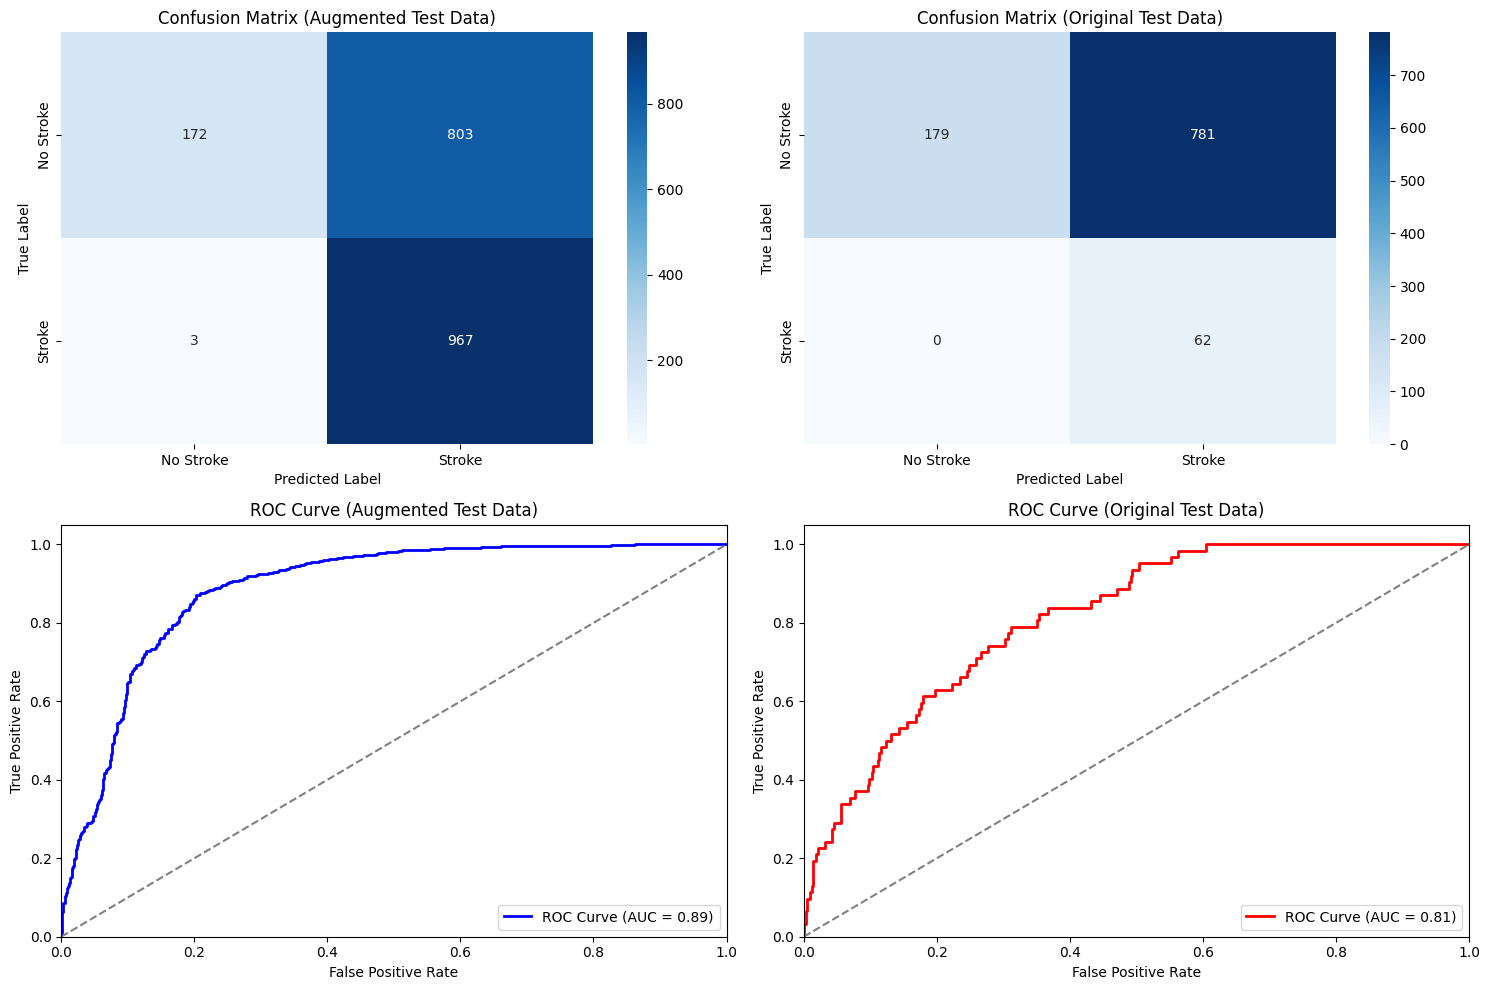


=== Model Performance on Augmented Test Data ===
Accuracy: 0.5856041131105398
Confusion Matrix:
 [[172 803]
 [  3 967]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.18      0.30       975
           1       0.55      1.00      0.71       970

    accuracy                           0.59      1945
   macro avg       0.76      0.59      0.50      1945
weighted avg       0.77      0.59      0.50      1945


=== Model Performance on Original Test Data ===
Accuracy: 0.23581213307240703
Confusion Matrix:
 [[179 781]
 [  0  62]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.19      0.31       960
           1       0.07      1.00      0.14        62

    accuracy                           0.24      1022
   macro avg       0.54      0.59      0.23      1022
weighted avg       0.94      0.24      0.30      1022


=== Detailed Metrics for Augmented Test Data ===
Sensit

In [12]:
# 9. Visualize results
plt.figure(figsize=(15, 10))

# Plot confusion matrix for augmented test data
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix (Augmented Test Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot confusion matrix for original test data
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_original, 
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix (Original Test Data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC curve for augmented test data
plt.subplot(2, 2, 3)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Augmented Test Data)')
plt.legend(loc="lower right")

# ROC curve for original test data
plt.subplot(2, 2, 4)
y_pred_prob_original = model.predict_proba(X_test_original_scaled)[:, 1]
fpr_orig, tpr_orig, _ = roc_curve(y_test_original, y_pred_prob_original)
roc_auc_orig = auc(fpr_orig, tpr_orig)
plt.plot(fpr_orig, tpr_orig, color='red', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_orig:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Test Data)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print metrics for both evaluations
print("\n=== Model Performance on Augmented Test Data ===")
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

print("\n=== Model Performance on Original Test Data ===")
print("Accuracy:", accuracy_original)
print("Confusion Matrix:\n", conf_matrix_original)
print("Classification Report:\n", class_report_original)

# Calculate and print additional metrics for both approaches
def print_detailed_metrics(conf_matrix, title):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    print(f"\n=== Detailed Metrics for {title} ===")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")

print_detailed_metrics(conf_matrix, "Augmented Test Data")
print_detailed_metrics(conf_matrix_original, "Original Test Data")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

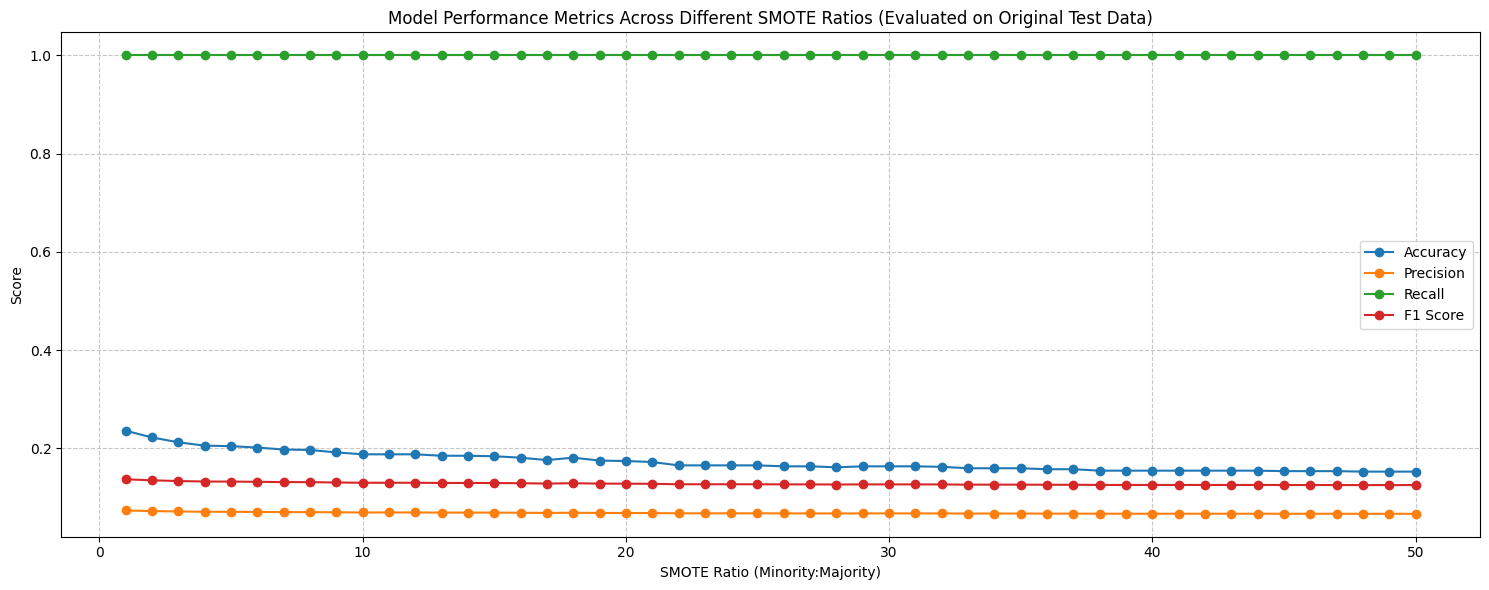

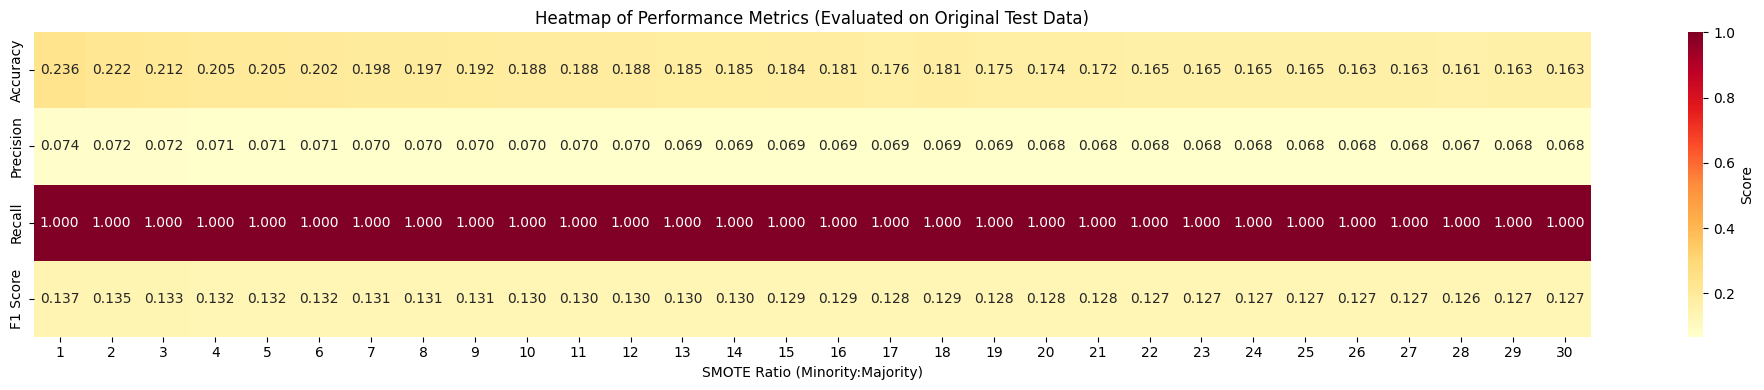


Best Ratios for Each Metric (Evaluated on Original Test Data):
Accuracy: Ratio 1:1 (Score: 0.236)
Precision: Ratio 1:1 (Score: 0.074)
Recall: Ratio 1:1 (Score: 1.000)
F1 Score: Ratio 1:1 (Score: 0.137)


In [13]:
# Collect metrics for different SMOTE ratios
ratios = list(range(1,51))
results = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}
for ratio in ratios:
    # Apply SMOTE with different ratios
    smote = SMOTE(sampling_strategy={0: len(y[y==0]), 1: ratio*len(y[y==0])}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Train model on resampled data
    X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_resampled = scaler.fit_transform(X_train_resampled)

    # Transform the ORIGINAL test data using the same scaler
    X_test_original_scaled = scaler.transform(X_test_original)

    # Train model and predict on original test data
    model = GaussianNB()
    model.fit(X_train_resampled, y_train_resampled)
    y_pred_original = model.predict(X_test_original_scaled)

    # Calculate metrics using original test data
    results['Accuracy'].append(accuracy_score(y_test_original, y_pred_original))
    results['Precision'].append(precision_score(y_test_original, y_pred_original))
    results['Recall'].append(recall_score(y_test_original, y_pred_original))
    results['F1 Score'].append(f1_score(y_test_original, y_pred_original))

    print(f"{ratio} ", end="")
    
# Create first figure for line plot
plt.figure(figsize=(15, 6))
for metric in results.keys():
    plt.plot(ratios, results[metric], marker='o', label=metric)
plt.xlabel('SMOTE Ratio (Minority:Majority)')
plt.ylabel('Score')
plt.title('Model Performance Metrics Across Different SMOTE Ratios (Evaluated on Original Test Data)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Create second figure for heatmap
plt.figure(figsize=(20, 4))
heatmap_data = np.array([results[metric][:30] for metric in results.keys()])
sns.heatmap(heatmap_data, 
            annot=True,
            fmt='.3f',
            xticklabels=range(1, 31),  # Limited to 1-30
            yticklabels=results.keys(),
            cmap='YlOrRd',
            annot_kws={'size': 10},
            cbar_kws={'label': 'Score'})
plt.xlabel('SMOTE Ratio (Minority:Majority)')
plt.title('Heatmap of Performance Metrics (Evaluated on Original Test Data)')
plt.tight_layout()
plt.show()

# Print the best ratio for each metric
print("\nBest Ratios for Each Metric (Evaluated on Original Test Data):")
for metric in results.keys():
    best_ratio = ratios[np.argmax(results[metric])]
    best_score = max(results[metric])
    print(f"{metric}: Ratio {best_ratio}:1 (Score: {best_score:.3f})")